# CSGODATA PROCESS


**Group 13 课程设计**

张一鸣 3019234068  

日期：2022/5/9

## Intro of DataSet

数据集：https://www.kaggle.com/datasets/skihikingkevin/csgo-matchmaking-damage


飞书中查看各表的字段：https://ulahdzk9l7.feishu.cn/docs/doccns9vTqkGv6I2MCKwGiJLfAd


本数据集包括以下表：

- Meta_demos
- master_dmg
- master_kills
- master_grenade
- mm_master

使用 `sc.textFile()` 读取HDFS中的 `csv` 表格，经过滤后存为 RDD 对象。

In [1]:
sc.master

'yarn'

# 数据集导入

## meta_demo 表的导入和处理

主表字段：

file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val

In [2]:
#导入数据表
#表头
meta_header = sc.textFile("/spark/csgodata/esea_meta_demos.part1.csv").first()
#raw data 创建RDD
meta_1_RDD = sc.textFile("/spark/csgodata/esea_meta_demos.part1.csv").filter(lambda x:x !=meta_header).map(lambda x: x.split(","))
meta_2_RDD = sc.textFile("/spark/csgodata/esea_meta_demos.part2.csv").filter(lambda x:x !=meta_header).map(lambda x: x.split(","))

In [3]:
print(meta_1_RDD.count())
print(meta_2_RDD.count())

215919
161710


In [4]:
meta_RDD=meta_1_RDD.union(meta_2_RDD)

In [5]:
meta_RDD.count()

377629

In [6]:
#meta_RDD.take(5)

### 创建 DF：

In [6]:
#不要每次要执行捏
sqlContext = SparkSession.builder.getOrCreate()

In [7]:
#创建DF
from pyspark.sql import Row
meta = meta_RDD.map(lambda p:
     Row(
         file=p[0], 
         map=p[1],
         round=int(p[2]),
         start_seconds=p[3],
         end_seconds=p[4],
         winner_team=p[5],
         winner_side=p[6],
         round_type=p[7],
         ct_eq_val=int(p[8]),
         t_eq_val=int(p[9])
    )
)
meta.take(5)
#'file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val'

[Row(ct_eq_val=4300, end_seconds='160.9591', file='esea_match_13770997.dem', map='de_overpass', round=1, round_type='PISTOL_ROUND', start_seconds='94.30781999999999', t_eq_val=4250, winner_side='Terrorist', winner_team='Hentai Hooligans'),
 Row(ct_eq_val=6300, end_seconds='279.3998', file='esea_match_13770997.dem', map='de_overpass', round=2, round_type='ECO', start_seconds='160.9591', t_eq_val=19400, winner_side='Terrorist', winner_team='Hentai Hooligans'),
 Row(ct_eq_val=7650, end_seconds='341.0084', file='esea_match_13770997.dem', map='de_overpass', round=3, round_type='SEMI_ECO', start_seconds='279.3998', t_eq_val=19250, winner_side='Terrorist', winner_team='Hentai Hooligans'),
 Row(ct_eq_val=24900, end_seconds='435.4259', file='esea_match_13770997.dem', map='de_overpass', round=4, round_type='NORMAL', start_seconds='341.0084', t_eq_val=23400, winner_side='Terrorist', winner_team='Hentai Hooligans'),
 Row(ct_eq_val=5400, end_seconds='484.2398', file='esea_match_13770997.dem', map='

In [8]:
meta_df = sqlContext.createDataFrame(meta)
meta_df.printSchema()

root
 |-- ct_eq_val: long (nullable = true)
 |-- end_seconds: string (nullable = true)
 |-- file: string (nullable = true)
 |-- map: string (nullable = true)
 |-- round: long (nullable = true)
 |-- round_type: string (nullable = true)
 |-- start_seconds: string (nullable = true)
 |-- t_eq_val: long (nullable = true)
 |-- winner_side: string (nullable = true)
 |-- winner_team: string (nullable = true)



In [10]:
meta_df.show(5)

+---------+-----------+--------------------+-----------+-----+------------+-----------------+--------+----------------+----------------+
|ct_eq_val|end_seconds|                file|        map|round|  round_type|    start_seconds|t_eq_val|     winner_side|     winner_team|
+---------+-----------+--------------------+-----------+-----+------------+-----------------+--------+----------------+----------------+
|     4300|   160.9591|esea_match_137709...|de_overpass|    1|PISTOL_ROUND|94.30781999999999|    4250|       Terrorist|Hentai Hooligans|
|     6300|   279.3998|esea_match_137709...|de_overpass|    2|         ECO|         160.9591|   19400|       Terrorist|Hentai Hooligans|
|     7650|   341.0084|esea_match_137709...|de_overpass|    3|    SEMI_ECO|         279.3998|   19250|       Terrorist|Hentai Hooligans|
|    24900|   435.4259|esea_match_137709...|de_overpass|    4|      NORMAL|         341.0084|   23400|       Terrorist|Hentai Hooligans|
|     5400|   484.2398|esea_match_137709.

In [11]:
#注册TempTable
meta_df.registerTempTable("meta_table")
sqlContext.sql(" SELECT count(*) counts FROM meta_table").show()
#后面的表，用时再注册

+------+
|counts|
+------+
|377629|
+------+



## master_dmg表的导入

'file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,
 bomb_site,hitbox,wp,wp_type,[att_id,att_rank,vic_id,vic_rank],att_pos_x,att_pos_y,vic_pos_x,vic_pos_y'

In [9]:
#导入数据表
#表头
dmg_header = sc.textFile("/spark/csgodata/esea_master_dmg_demos.part1.csv").first()
#raw data 创建RDD
dmg_1_RDD = sc.textFile("/spark/csgodata/esea_master_dmg_demos.part1.csv").filter(lambda x:x !=dmg_header).map(lambda x: x.split(","))
dmg_2_RDD = sc.textFile("/spark/csgodata/esea_master_dmg_demos.part2.csv").filter(lambda x:x !=dmg_header).map(lambda x: x.split(","))

In [13]:
print(dmg_1_RDD.count())
print(dmg_2_RDD.count())

5992097
4546085


In [10]:
dmg_RDD=dmg_1_RDD.union(dmg_2_RDD)
#dmg_RDD.count()

In [15]:
#dmg_RDD.take(2)
dmg_header

'file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,bomb_site,hitbox,wp,wp_type,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y'

In [11]:
#创建DF
sqlContext = SparkSession.builder.getOrCreate()
from pyspark.sql import Row
dmg_tmp = dmg_RDD.map(lambda p:
     Row(
         file=p[0], 
         round=p[1],
         tick=p[2],
         seconds=p[3],
         att_team=p[4],
         vic_team=p[5],
         att_side=p[6],
         vic_side=p[7],
         hp_dmg=p[8],
         arm_dmg=p[9],
         is_bomb_planted=p[10],
         bomb_site=p[11],
         hitbox=p[12],
         wp=p[13],
         wp_type=p[14],
         att_pos_x=p[19],
         att_pos_y=p[20],
         vic_pos_x=p[21],
         vic_pos_y=p[22]
    )
)

创建dmg_df：

In [12]:
dmg_df = sqlContext.createDataFrame(dmg_tmp)
dmg_df.printSchema()
#'file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,
# bomb_site,hitbox,wp,wp_type,[att_id,att_rank,vic_id,vic_rank],att_pos_x,att_pos_y,vic_pos_x,vic_pos_y'

root
 |-- arm_dmg: string (nullable = true)
 |-- att_pos_x: string (nullable = true)
 |-- att_pos_y: string (nullable = true)
 |-- att_side: string (nullable = true)
 |-- att_team: string (nullable = true)
 |-- bomb_site: string (nullable = true)
 |-- file: string (nullable = true)
 |-- hitbox: string (nullable = true)
 |-- hp_dmg: string (nullable = true)
 |-- is_bomb_planted: string (nullable = true)
 |-- round: string (nullable = true)
 |-- seconds: string (nullable = true)
 |-- tick: string (nullable = true)
 |-- vic_pos_x: string (nullable = true)
 |-- vic_pos_y: string (nullable = true)
 |-- vic_side: string (nullable = true)
 |-- vic_team: string (nullable = true)
 |-- wp: string (nullable = true)
 |-- wp_type: string (nullable = true)



In [18]:
dmg_df.show(5)

+-------+---------+-------------------+----------------+----------------+---------+--------------------+--------+------+---------------+-----+--------+-----+---------+------------------+----------------+----------------+-------+-------+
|arm_dmg|att_pos_x|          att_pos_y|        att_side|        att_team|bomb_site|                file|  hitbox|hp_dmg|is_bomb_planted|round| seconds| tick|vic_pos_x|         vic_pos_y|        vic_side|        vic_team|     wp|wp_type|
+-------+---------+-------------------+----------------+----------------+---------+--------------------+--------+------+---------------+-----+--------+-----+---------+------------------+----------------+----------------+-------+-------+
|      0|      0.0|                0.0|            None|           World|         |esea_match_137709...| Generic|     1|          False|    1|111.8476|14372|      0.0|               0.0|CounterTerrorist|    Animal Style|Unknown| Unkown|
|      9| -1499.69|           63.33829|CounterTerror

## master_kill 表的导入

file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted

In [13]:
#导入数据表
#表头
kill_header = sc.textFile("/spark/csgodata/esea_master_kills_demos.part1.csv").first()
#raw data 创建RDD
kill_1_RDD = sc.textFile("/spark/csgodata/esea_master_kills_demos.part1.csv").filter(lambda x:x !=kill_header).map(lambda x: x.split(","))
kill_2_RDD = sc.textFile("/spark/csgodata/esea_master_kills_demos.part2.csv").filter(lambda x:x !=kill_header).map(lambda x: x.split(","))

In [14]:
kill_RDD=kill_1_RDD.union(kill_2_RDD)
#kill_RDD.count()

In [21]:
kill_header

'file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted'

In [15]:
#创建DF
#sqlContext = SparkSession.builder.getOrCreate()
from pyspark.sql import Row
kill_tmp = kill_RDD.map(lambda p:
     Row(
         file=p[0], 
         round=p[1],
         tick=p[2],
         seconds=p[3],
         att_team=p[4],
         vic_team=p[5],
         att_side=p[6],
         vic_side=p[7],
         ct_alive=p[10],
         t_alive=p[11],
         is_bomb_planted=p[12],
         bomb_site=p[11],
         wp=p[8],
         wp_type=p[9]
    )
)

In [16]:
kill_df = sqlContext.createDataFrame(kill_tmp)
kill_df.printSchema()
#'file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted'

root
 |-- att_side: string (nullable = true)
 |-- att_team: string (nullable = true)
 |-- bomb_site: string (nullable = true)
 |-- ct_alive: string (nullable = true)
 |-- file: string (nullable = true)
 |-- is_bomb_planted: string (nullable = true)
 |-- round: string (nullable = true)
 |-- seconds: string (nullable = true)
 |-- t_alive: string (nullable = true)
 |-- tick: string (nullable = true)
 |-- vic_side: string (nullable = true)
 |-- vic_team: string (nullable = true)
 |-- wp: string (nullable = true)
 |-- wp_type: string (nullable = true)



In [24]:
kill_df.show(5)

+----------------+----------------+---------+--------+--------------------+---------------+-----+--------+-------+-----+----------------+----------------+-----+-------+
|        att_side|        att_team|bomb_site|ct_alive|                file|is_bomb_planted|round| seconds|t_alive| tick|        vic_side|        vic_team|   wp|wp_type|
+----------------+----------------+---------+--------+--------------------+---------------+-----+--------+-------+-----+----------------+----------------+-----+-------+
|CounterTerrorist|    Animal Style|        4|       5|esea_match_137709...|          False|    1|30.74165|      4|16058|       Terrorist|Hentai Hooligans|  USP| Pistol|
|       Terrorist|Hentai Hooligans|        4|       4|esea_match_137709...|          False|    1|31.93185|      4|16210|CounterTerrorist|    Animal Style|Glock| Pistol|
|       Terrorist|Hentai Hooligans|        4|       3|esea_match_137709...|          False|    1|34.28094|      4|16510|CounterTerrorist|    Animal Style|G

## master_grenade 表的导入

'file,round,seconds,att_team,vic_team,att_id,vic_id,att_side,vic_side,hp_dmg,arm_dmg,

is_bomb_planted,bomb_site,hitbox,nade,att_rank,vic_rank,att_pos_x,att_pos_y,nade_land_x,nade_land_y,vic_pos_x,vic_pos_y'

In [25]:
#导入数据表
#表头
gre_header = sc.textFile("/spark/csgodata/esea_master_grenades_demos.part1.csv").first()
#raw data 创建RDD
gre_1_RDD = sc.textFile("/spark/csgodata/esea_master_grenades_demos.part1.csv").filter(lambda x:x !=gre_header).map(lambda x: x.split(","))
gre_2_RDD = sc.textFile("/spark/csgodata/esea_master_grenades_demos.part2.csv").filter(lambda x:x !=gre_header).map(lambda x: x.split(","))

In [26]:
gre_RDD=gre_1_RDD.union(gre_2_RDD)
gre_RDD.count()

5246458

In [27]:
gre_header

'file,round,seconds,att_team,vic_team,att_id,vic_id,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,bomb_site,hitbox,nade,att_rank,vic_rank,att_pos_x,att_pos_y,nade_land_x,nade_land_y,vic_pos_x,vic_pos_y'

In [28]:
#创建DF
#sqlContext = SparkSession.builder.getOrCreate()
#from pyspark.sql import Row
gre_tmp = gre_RDD.map(lambda p:
     Row(
         file=p[0], 
         round=p[1],
         seconds=p[2],
         att_team=p[3],
         vic_team=p[4],
         att_side=p[7],
         vic_side=p[8],
         hp_dmg=p[9],
         arm_dmg=p[10],
         is_bomb_planted=p[11],
         bomb_site=p[12],
         hitbox=p[13],
         nade=p[14],
         att_pos_x=p[17],
         att_pos_y=p[18],
         nade_land_x=p[19],
         nade_land_y=p[20],
         vic_pos_x=p[21],
         vic_pos_y=p[22]
    )
)

In [29]:
gre_df = sqlContext.createDataFrame(gre_tmp)
gre_df.printSchema()

root
 |-- arm_dmg: string (nullable = true)
 |-- att_pos_x: string (nullable = true)
 |-- att_pos_y: string (nullable = true)
 |-- att_side: string (nullable = true)
 |-- att_team: string (nullable = true)
 |-- bomb_site: string (nullable = true)
 |-- file: string (nullable = true)
 |-- hitbox: string (nullable = true)
 |-- hp_dmg: string (nullable = true)
 |-- is_bomb_planted: string (nullable = true)
 |-- nade: string (nullable = true)
 |-- nade_land_x: string (nullable = true)
 |-- nade_land_y: string (nullable = true)
 |-- round: string (nullable = true)
 |-- seconds: string (nullable = true)
 |-- vic_pos_x: string (nullable = true)
 |-- vic_pos_y: string (nullable = true)
 |-- vic_side: string (nullable = true)
 |-- vic_team: string (nullable = true)



In [30]:
gre_df.show(5)

+-------+-------------------+-------------------+----------------+----------------+---------+--------------------+-------+------+---------------+-------+-------------------+-----------+-----+--------+---------+-------------------+----------------+------------+
|arm_dmg|          att_pos_x|          att_pos_y|        att_side|        att_team|bomb_site|                file| hitbox|hp_dmg|is_bomb_planted|   nade|        nade_land_x|nade_land_y|round| seconds|vic_pos_x|          vic_pos_y|        vic_side|    vic_team|
+-------+-------------------+-------------------+----------------+----------------+---------+--------------------+-------+------+---------------+-------+-------------------+-----------+-----+--------+---------+-------------------+----------------+------------+
|      0|          -1618.146|          -66.00259|CounterTerrorist|    Animal Style|        B|esea_match_137709...|       |     0|           True|  Smoke|          -949.8569|  -340.3019|    1|153.1602|         |       

## mm表的导入

这一部分主要做段位分析，有时间再做。

mm_master字段：

',file,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,

bomb_site,hitbox,wp,wp_type,award,winner_team,winner_side,att_id,att_rank,vic_id,vic_rank,att_pos_x,

att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank'

In [31]:
#导入数据表
#表头
mmmaster_header = sc.textFile("/spark/csgodata/mm_master_demos.csv").first()
#raw data 创建RDD
mmmaster_RDD = sc.textFile("/spark/csgodata/mm_master_demos.csv").filter(lambda x:x !=mmmaster_header).map(lambda x: x.split(","))

In [32]:
mmmaster_RDD.count()

955466

In [33]:
mmmaster_header

',file,map,date,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted,bomb_site,hitbox,wp,wp_type,award,winner_team,winner_side,att_id,att_rank,vic_id,vic_rank,att_pos_x,att_pos_y,vic_pos_x,vic_pos_y,round_type,ct_eq_val,t_eq_val,avg_match_rank'

In [34]:
#创建DF
#sqlContext = SparkSession.builder.getOrCreate()
#from pyspark.sql import Row
"""
mmmaster_tmp = dmg_RDD.map(lambda p:
     Row(
         file=p[0], 
         map=p[1],
         date=p[3],
         round=p[4],
         seconds=p[5],
         att_team=p[6],
         vic_side=p[7],
         hp_dmg=p[8],
         arm_dmg=p[9],
         is_bomb_planted=p[10],
         bomb_site=p[11],
         hitbox=p[12],
         wp=p[13],
         wp_type=p[14],
         att_pos_x=p[19],
         att_pos_y=p[20],
         vic_pos_x=p[21],
         vic_pos_y=p[22]
    )
)
"""

'\nmmmaster_tmp = dmg_RDD.map(lambda p:\n     Row(\n         file=p[0], \n         map=p[1],\n         date=p[3],\n         round=p[4],\n         seconds=p[5],\n         att_team=p[6],\n         vic_side=p[7],\n         hp_dmg=p[8],\n         arm_dmg=p[9],\n         is_bomb_planted=p[10],\n         bomb_site=p[11],\n         hitbox=p[12],\n         wp=p[13],\n         wp_type=p[14],\n         att_pos_x=p[19],\n         att_pos_y=p[20],\n         vic_pos_x=p[21],\n         vic_pos_y=p[22]\n    )\n)\n'

# 主表分析

## 地图胜率分析

- 下面这一部分尝试使用整局比赛计算胜率

选择file、map、round、winner_side显示：

In [35]:
map_winrate_RAW=meta_df.select(meta_df.file, meta_df.map, 'round',meta_df.winner_side)
map_winrate_RAW.show(10)

+--------------------+-----------+-----+----------------+
|                file|        map|round|     winner_side|
+--------------------+-----------+-----+----------------+
|esea_match_137709...|de_overpass|    1|       Terrorist|
|esea_match_137709...|de_overpass|    2|       Terrorist|
|esea_match_137709...|de_overpass|    3|       Terrorist|
|esea_match_137709...|de_overpass|    4|       Terrorist|
|esea_match_137709...|de_overpass|    5|CounterTerrorist|
|esea_match_137709...|de_overpass|    6|       Terrorist|
|esea_match_137709...|de_overpass|    7|       Terrorist|
|esea_match_137709...|de_overpass|    8|CounterTerrorist|
|esea_match_137709...|de_overpass|    9|CounterTerrorist|
|esea_match_137709...|de_overpass|   10|CounterTerrorist|
+--------------------+-----------+-----+----------------+
only showing top 10 rows



In [36]:
map_winrate_1_pd=map_winrate_RAW.groupby("map","file","winner_side").count().orderBy("map","file","winner_side").toPandas()
map_winrate_1_pd

,map,file,winner_side,count
0,de_cache,esea_match_13779704.dem,CounterTerrorist,19
1,de_cache,esea_match_13779704.dem,Terrorist,20
2,de_cache,esea_match_13779787.dem,CounterTerrorist,13
3,de_cache,esea_match_13779787.dem,Terrorist,16
4,de_cache,esea_match_13779789.dem,CounterTerrorist,15
5,de_cache,esea_match_13779789.dem,Terrorist,12
6,de_cache,esea_match_13779805.dem,CounterTerrorist,7
7,de_cache,esea_match_13779805.dem,Terrorist,22
8,de_cache,esea_match_13779806.dem,CounterTerrorist,18
9,de_cache,esea_match_13779806.dem,Terrorist,8


- 只统计每回合的胜率

In [37]:
#显示地图和胜利的一方
#'file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val'
map_winrate=meta_df.select(meta_df.file, meta_df.map, meta_df.winner_side ).\
                filter("winner_side!='None'").\
                groupby("map","winner_side").count().\
                orderBy("map","winner_side")
map_winrate.show(10)

+----------+----------------+-----+
|       map|     winner_side|count|
+----------+----------------+-----+
|  de_cache|CounterTerrorist|60817|
|  de_cache|       Terrorist|67207|
|  de_cbble|CounterTerrorist| 2746|
|  de_cbble|       Terrorist| 3046|
|  de_dust2|CounterTerrorist| 9335|
|  de_dust2|       Terrorist|10890|
|de_inferno|CounterTerrorist|25034|
|de_inferno|       Terrorist|27842|
| de_mirage|CounterTerrorist|66373|
| de_mirage|       Terrorist|66488|
+----------+----------------+-----+
only showing top 10 rows



In [38]:
map_winrate_pd=map_winrate.toPandas()#.set_index('map')
map_winrate_pd

,map,winner_side,count
0,de_cache,CounterTerrorist,60817
1,de_cache,Terrorist,67207
2,de_cbble,CounterTerrorist,2746
3,de_cbble,Terrorist,3046
4,de_dust2,CounterTerrorist,9335
5,de_dust2,Terrorist,10890
6,de_inferno,CounterTerrorist,25034
7,de_inferno,Terrorist,27842
8,de_mirage,CounterTerrorist,66373
9,de_mirage,Terrorist,66488


### 地图胜率分析绘图

In [12]:
import matplotlib.pyplot as plt

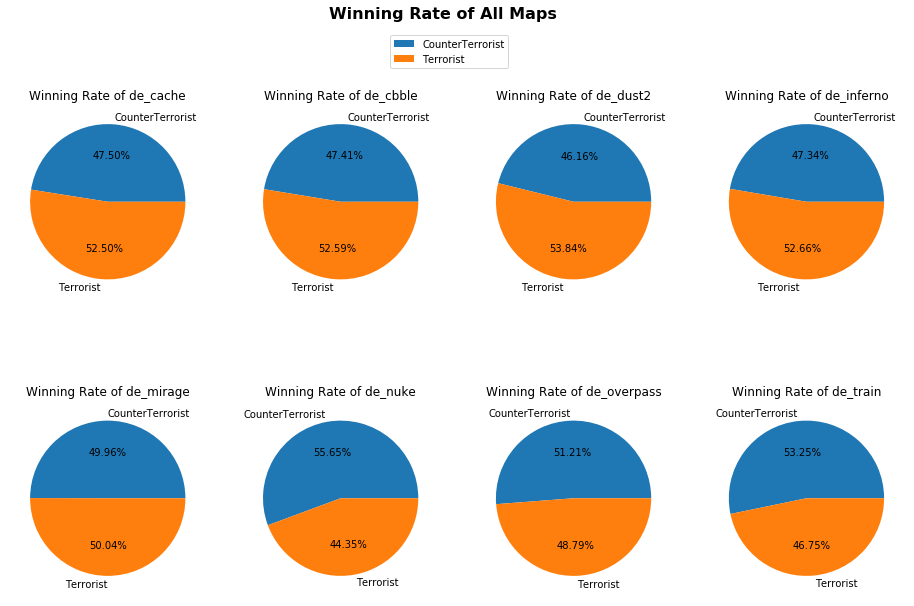

In [40]:
fig=plt.figure(figsize=(16,10))
#axes = fig.subplots(nrows=2, ncols=4)

plt.suptitle('Winning Rate of All Maps', fontsize=16, fontweight='bold')
#设置了j后面一次循环结束就加一，可以对应画布上的位置
j=1
#用unique()方法去重
for map in map_winrate_pd.map.unique(): 
    plt.subplot(2,4,j)
    plt.title('Winning Rate of %s' % map)
    Winrate_Pie=map_winrate_pd[map_winrate_pd['map']==map]
    plt.pie(Winrate_Pie['count'],labels=Winrate_Pie['winner_side'],autopct='%1.2f%%')
    j=j+1
    
labels = map_winrate_pd['winner_side'].unique()
#plt.tight_layout()
fig.legend(labels,loc='upper center',bbox_to_anchor=(0.39, 0.8))
plt.show()

此图表显示的是全部回合的胜率，

$$
    \rm{Win\ Rate\ by\ round} =\frac{\rm{Win \ rounds}}{\rm{ALL \ rounds}} \tag{1}
$$

若使用整局比赛获胜判断胜率：

$$
    \rm{Win\ Rate\ by\ play} =\frac{\rm{Win \ plays}}{\rm{ALL \ plays}} \tag{2}
$$

二者取得的结果相差在 $0.1\%$ 内，故本记事本中使用更好计算的 $(1)$ 式计算

## 经济的影响

In [14]:
economics_RAW=meta_df.select('file', 'map', 'round','round_type','ct_eq_val','t_eq_val')
economics_RAW.show(10)

+--------------------+-----------+-----+------------+---------+--------+
|                file|        map|round|  round_type|ct_eq_val|t_eq_val|
+--------------------+-----------+-----+------------+---------+--------+
|esea_match_137709...|de_overpass|    1|PISTOL_ROUND|     4300|    4250|
|esea_match_137709...|de_overpass|    2|         ECO|     6300|   19400|
|esea_match_137709...|de_overpass|    3|    SEMI_ECO|     7650|   19250|
|esea_match_137709...|de_overpass|    4|      NORMAL|    24900|   23400|
|esea_match_137709...|de_overpass|    5|         ECO|     5400|   20550|
|esea_match_137709...|de_overpass|    6|      NORMAL|    29650|   25450|
|esea_match_137709...|de_overpass|    7|         ECO|     3200|   25300|
|esea_match_137709...|de_overpass|    8|         ECO|     4850|   27600|
|esea_match_137709...|de_overpass|    9|   FORCE_BUY|    32150|   18200|
|esea_match_137709...|de_overpass|   10|         ECO|    32950|    9950|
+--------------------+-----------+-----+-----------

一共有5种回合类型：ECO、手枪局、半ECO、强制购买、正常：

In [15]:
round_type_pd=economics_RAW.groupBy('round_type').count().toPandas()
round_type_pd

,round_type,count
0,ECO,128613
1,PISTOL_ROUND,28114
2,SEMI_ECO,24444
3,FORCE_BUY,40876
4,NORMAL,155582


In [17]:
print(round_type_pd.to_latex())

\begin{tabular}{llr}
\toprule
{} &    round\_type &   count \\
\midrule
0 &           ECO &  128613 \\
1 &  PISTOL\_ROUND &   28114 \\
2 &      SEMI\_ECO &   24444 \\
3 &     FORCE\_BUY &   40876 \\
4 &        NORMAL &  155582 \\
\bottomrule
\end{tabular}



In [14]:
#不用每次都执行捏
import seaborn as sns

### 不同回合类型的统计：

Text(0.5, 0.98, 'Round Types Statistics')

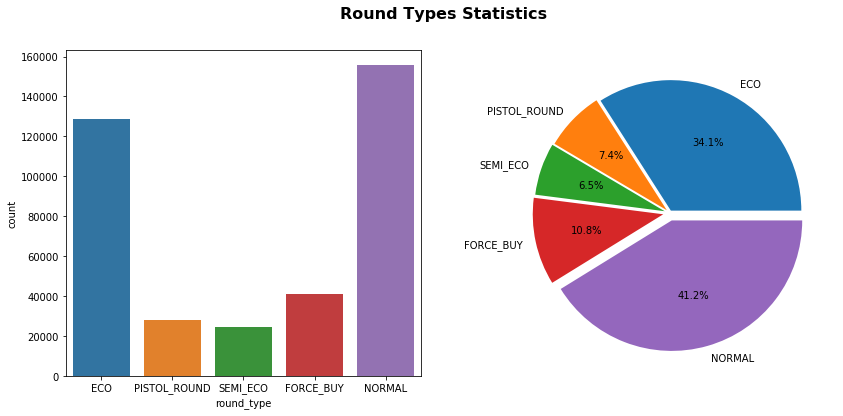

In [44]:
fig = plt.figure(figsize=(14, 6))
#画条形图📊
plt.subplot(1,2,1)
sns.barplot(x=round_type_pd['round_type'],y=round_type_pd['count'])
#画饼图
plt.subplot(1,2,2)
plt.pie(round_type_pd['count'],labels=round_type_pd['round_type'],autopct='%1.1f%%',explode = (0.02,0.03,0.04,0.05,0.06))
plt.suptitle('Round Types Statistics', fontsize=16, fontweight='bold')

可以看出最多的回合时正常长枪局，其次多的是ECO。

 不同局对应的经济：

引用画图的代码：

> ```python
fig = plt.figure(figsize=(10, 5))
sns.kdeplot(weapon_events['ct_eq_val'].rename('Counter-Terrorists'))
sns.kdeplot(weapon_events['t_eq_val'].rename('Terrorists'))
plt.suptitle("Team Round Spend Values")
>```

### T与CT的经济对比

画图：

In [45]:
#显示各round_type的T和CT的经济
eco_pd=economics_RAW.select('round_type','ct_eq_val','t_eq_val').\
orderBy('t_eq_val',ascending=0 ).toPandas()
eco_pd

,round_type,ct_eq_val,t_eq_val
0,FORCE_BUY,19750,38150
1,NORMAL,33700,37900
2,NORMAL,29550,37400
3,FORCE_BUY,19450,36950
4,NORMAL,29500,36900
5,ECO,10200,36700
6,NORMAL,34200,36450
7,NORMAL,30850,36350
8,FORCE_BUY,18800,36350
9,NORMAL,26350,36250


根据经济数据，画概率分布图：

**（这部分要是图太大，就不逃这样套子图了，就分开两个图画）**

Text(0.5, 0.98, 'Economics Distribution Estimation')

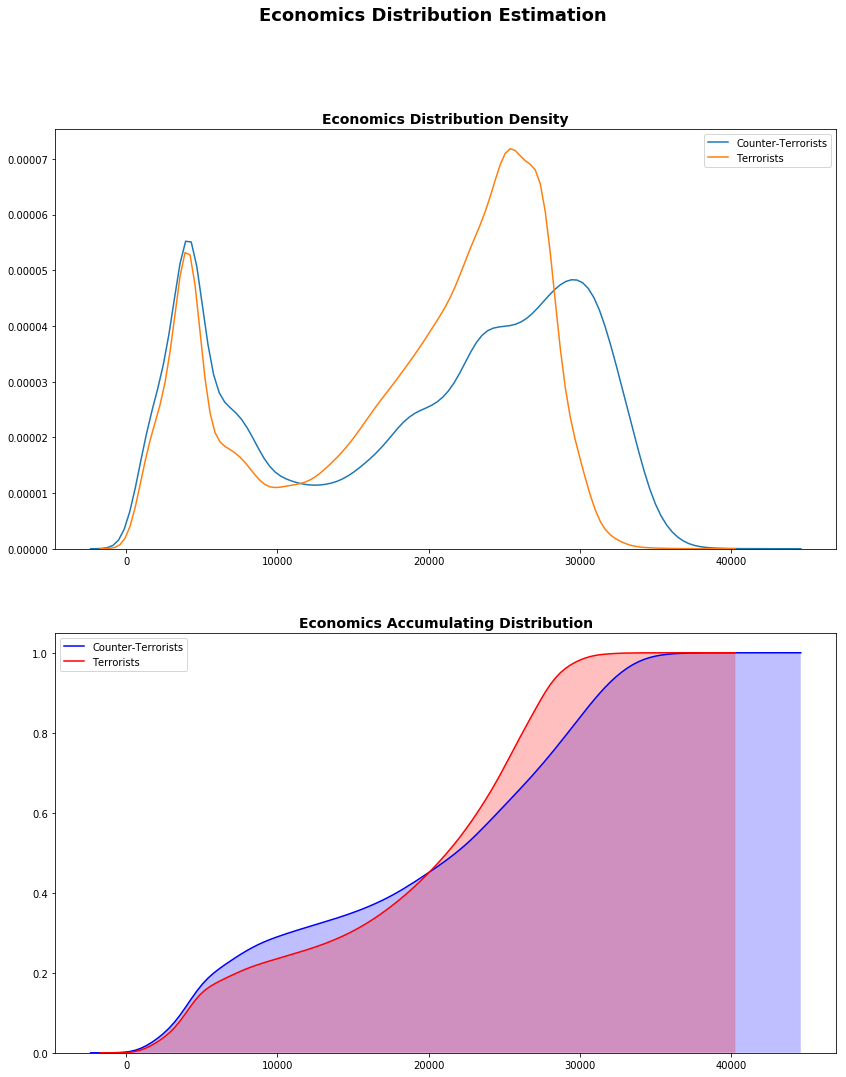

In [46]:
fig = plt.figure(figsize=(14, 17))

#画概率密度函数
plt.subplot(2,1,1)
plt.title('Economics Distribution Density', fontsize=14, fontweight='bold')
sns.kdeplot(eco_pd['ct_eq_val'].rename('Counter-Terrorists'))
sns.kdeplot(eco_pd['t_eq_val'].rename('Terrorists'))


#画概率分布函数
plt.subplot(2,1,2)
plt.title('Economics Accumulating Distribution', fontsize=14, fontweight='bold')
sns.kdeplot(eco_pd['ct_eq_val'].rename('Counter-Terrorists'),cumulative=True,shade=True,color='blue')
sns.kdeplot(eco_pd['t_eq_val'].rename('Terrorists'),cumulative=True,shade=True,color='red')

plt.suptitle('Economics Distribution Estimation', fontsize=18, fontweight='bold')

上图为T和CT的**经济概率密度**分布估计曲线，由此图可以看出CT的最高经济要高于T的经济。

T和CT均倾向于购买“很少的装备”或是“很多的装备”，

在低经济阶段（ECO），T与CT经济的最概然经济值基本相同；

在高经济阶段（超过\$ 20000），CT的最概然经济值要高于T的经济，这也可能是CT的装备价格要高于T

由下图的**经济累积分布**估计曲线也可同样看出此规律。

> 正如你所看到的，团队非常倾向于购买“几乎没有”或“很多”的装备。 有趣的是，在购买回合中，反恐精英的花费往往比恐怖分子略高，这可能是因为他们对可以购买的最大装备数量有更高的限制。

统计信息：

**画箱线图**

Text(0.5, 0.98, 'Economics Statiscs')

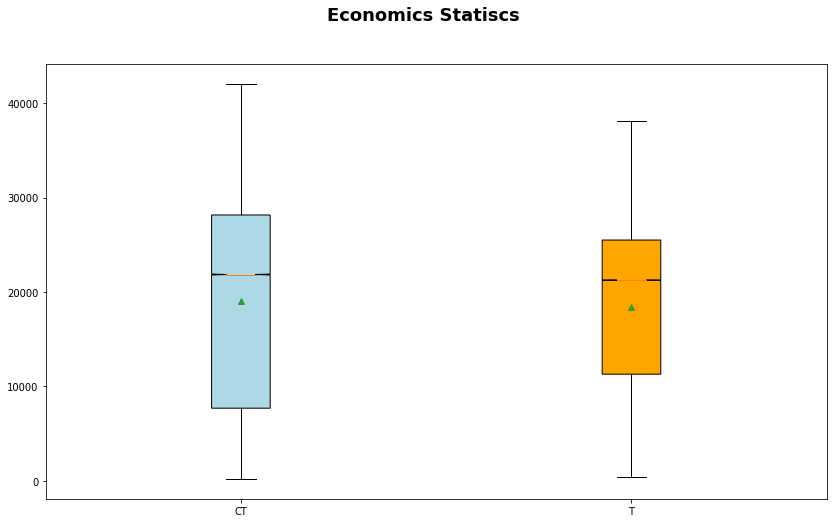

In [47]:
fig = plt.figure(figsize=(14, 8))

#画箱线图
bplot=plt.boxplot([eco_pd['ct_eq_val'],eco_pd['t_eq_val']],
                patch_artist=True,
                boxprops={'color': 'black'},
                notch=True, 
                showmeans=True,
                labels=['CT', 'T'])
colors = ['lightblue','orange']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

plt.suptitle('Economics Statiscs', fontsize=18, fontweight='bold')

CT的经济高于T的经济，同时波动性也更大，更容易ECO，这是游戏机制所设计的。

> 警察经济无论是中位数还是平均值，都要比土匪经济高一点点，这和游戏机制有关。而且明显看出，警察经济的波动更强。为何印象中做土匪可以把把刚枪？为何做警察经常ECO？结果说明，警察要控制经济，就比土匪难。

### 经济与道具使用的关系

我们考虑：

- 经济越高，越多使用道具

- 经济越高，胜率越高？

### 经济与T和CT胜率的关系

相关性分析。

# dmg表分析

## 武器伤害排行榜



一共有8种武器类型，击杀记录最多的是长枪

In [18]:
#列出不同伤害的武器类型
ddpd=dmg_df.select('wp_type').groupBy('wp_type').count().orderBy('count',ascending=0 ).toPandas()
ddpd

,wp_type,count
0,Rifle,5338372
1,Pistol,2070588
2,Grenade,1280516
3,SMG,1133901
4,Sniper,490912
5,Heavy,110201
6,Unkown,103280
7,Equipment,10412


In [19]:
print(ddpd.to_latex())

\begin{tabular}{llr}
\toprule
{} &    wp\_type &    count \\
\midrule
0 &      Rifle &  5338372 \\
1 &     Pistol &  2070588 \\
2 &    Grenade &  1280516 \\
3 &        SMG &  1133901 \\
4 &     Sniper &   490912 \\
5 &      Heavy &   110201 \\
6 &     Unkown &   103280 \\
7 &  Equipment &    10412 \\
\bottomrule
\end{tabular}



统计不同类型武器的总伤害量：

使用Data Frame：

In [19]:
#以wp_type区分的伤害，并计算总伤害
dmg_wp_list=dmg_df.select('wp','wp_type','hitbox','hp_dmg','arm_dmg',(dmg_df.hp_dmg+dmg_df.arm_dmg).alias("tot_dmg")).\
                    orderBy('wp_type')
#dmg_wp_list.show(50)

### 不同武器类型 `wp_type`

网上查到的求和方式，已弃用。

>```python
>#from pyspark.sql import functions as fn
>#from pyspark.sql import Window
>win = Window.orderBy('wp_type')
>dmg_df_tmp = dmg_wp_type_list.withColumn('sum_of_hp_dmg', fn.sum(dmg_wp_type_list['hp_dmg']).over(win))
>```

分组求和：

In [20]:
dmg_wp_type_sum=dmg_wp_list.groupBy('wp_type').agg({'hp_dmg': 'sum', 'arm_dmg': 'sum','tot_dmg': 'sum'}).\
                withColumnRenamed("sum(tot_dmg)", "tot_dmg").\
                withColumnRenamed("sum(hp_dmg)", "hp_dmg").\
                withColumnRenamed("sum(arm_dmg)", "arm_dmg").\
                orderBy('tot_dmg',ascending=0)
dmg_wp_type_sum_pd=dmg_wp_type_sum.toPandas()
dmg_wp_type_sum_pd

,wp_type,tot_dmg,hp_dmg,arm_dmg
0,Rifle,177745516.0,156448524.0,21296992.0
1,Pistol,76737824.0,67355345.0,9382479.0
2,Sniper,39695267.0,38710578.0,984689.0
3,SMG,27397275.0,23032905.0,4364370.0
4,Grenade,15249803.0,13021114.0,2228689.0
5,Heavy,2325035.0,2039414.0,285621.0
6,Unkown,1854692.0,1295327.0,559365.0
7,Equipment,583514.0,543252.0,40262.0


In [17]:
print(dmg_wp_type_sum_pd.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &    wp\_type &      tot\_dmg &       hp\_dmg &     arm\_dmg \\
\midrule
0 &      Rifle &  177745516.0 &  156448524.0 &  21296992.0 \\
1 &     Pistol &   76737824.0 &   67355345.0 &   9382479.0 \\
2 &     Sniper &   39695267.0 &   38710578.0 &    984689.0 \\
3 &        SMG &   27397275.0 &   23032905.0 &   4364370.0 \\
4 &    Grenade &   15249803.0 &   13021114.0 &   2228689.0 \\
5 &      Heavy &    2325035.0 &    2039414.0 &    285621.0 \\
6 &     Unkown &    1854692.0 &    1295327.0 &    559365.0 \\
7 &  Equipment &     583514.0 &     543252.0 &     40262.0 \\
\bottomrule
\end{tabular}



画图说明不同武器类型的**伤害量**排名：

Text(0.5, 0.98, 'Weapon Type Demage Counting')

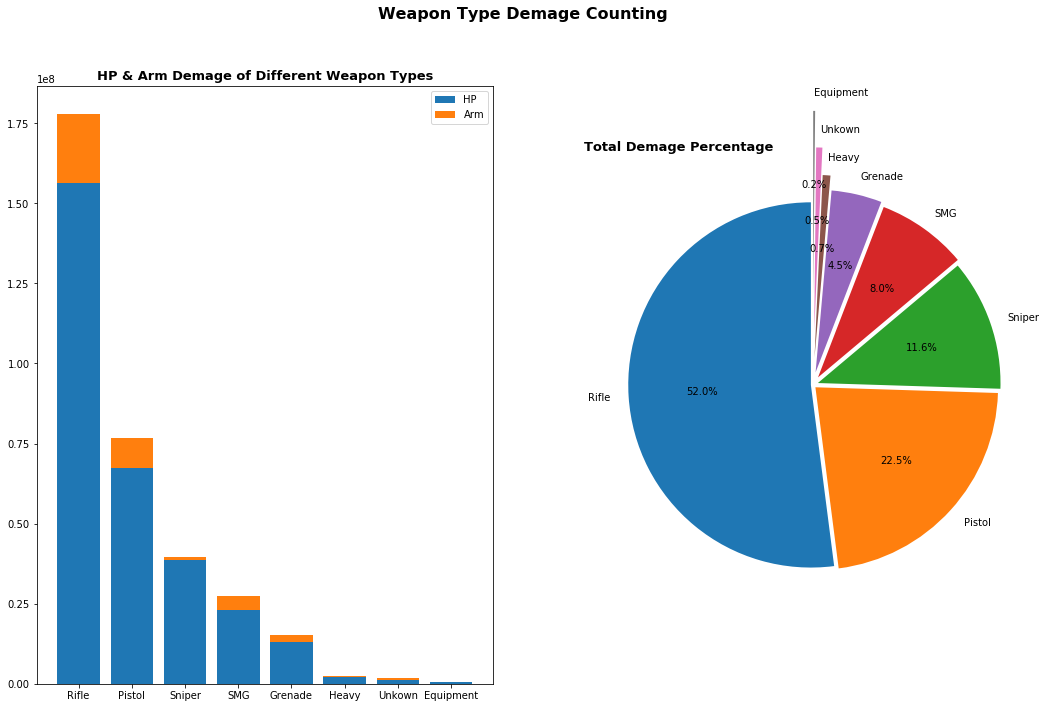

In [51]:
from matplotlib import ticker
fig = plt.figure(figsize=(18, 11))
plt.subplot(1,2,1)
plt.title('HP & Arm Demage of Different Weapon Types', fontsize=13, fontweight='bold')

"""
sns.barplot(y=dmg_wp_type_sum_pd['wp_type'],x=[dmg_wp_type_sum_pd['hp_dmg'],\
                                               dmg_wp_type_sum_pd['arm_dmg'],\
                                               dmg_wp_type_sum_pd['tot_dmg']])
"""
plt.bar(dmg_wp_type_sum_pd['wp_type'], dmg_wp_type_sum_pd['hp_dmg'], label='HP')
plt.bar(dmg_wp_type_sum_pd['wp_type'], dmg_wp_type_sum_pd['arm_dmg'], bottom=dmg_wp_type_sum_pd['hp_dmg'], label='Arm')
plt.legend()

#plt.bar(dmg_wp_type_sum_pd['hp_dmg'],dmg_wp_type_sum_pd['wp_type'], label='HP')
#plt.bar(dmg_wp_type_sum_pd['arm_dmg'],dmg_wp_type_sum_pd['wp_type'],left=dmg_wp_type_sum_pd['hp_dmg'], label='Arm')
#plt.legend()
#.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

plt.subplot(1,2,2)
plt.title('Total Demage Percentage', fontsize=13, fontweight='bold',loc="left")
plt.pie(dmg_wp_type_sum_pd['tot_dmg'],labels=dmg_wp_type_sum_pd['wp_type'],startangle=90,autopct='%1.1f%%',explode = (0.01,0.02,0.03,0.05,0.07,0.15,0.3,0.5))
plt.suptitle('Weapon Type Demage Counting', fontsize=16, fontweight='bold')

可以看到，长枪对于生命值（HP）还是护甲（Arm）的损伤均是最高的，其次是手枪，之后依次是狙击枪、冲锋枪、道具、重武器和装备。

Text(0.5, 0.98, 'Weapon Type Demage On HP & Arm')

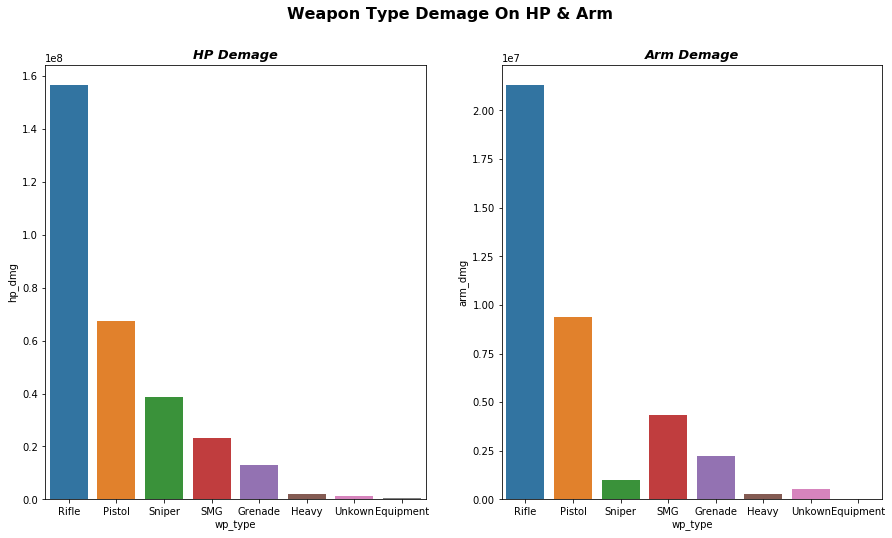

In [52]:
fig = plt.figure(figsize=(15, 8))
plt.subplot(1,2,1)
plt.title('HP Demage', fontsize=13, fontweight='bold',fontstyle='italic')
sns.barplot(x=dmg_wp_type_sum_pd['wp_type'],y=dmg_wp_type_sum_pd['hp_dmg'])
plt.subplot(1,2,2)
plt.title('Arm Demage', fontsize=13, fontweight='bold',fontstyle='italic')
sns.barplot(x=dmg_wp_type_sum_pd['wp_type'],y=dmg_wp_type_sum_pd['arm_dmg'])
                                             
#plt.bar(dmg_wp_type_sum_pd['wp_type'], dmg_wp_type_sum_pd['hp_dmg'], label='HP')
#plt.bar(dmg_wp_type_sum_pd['wp_type'], dmg_wp_type_sum_pd['arm_dmg'], bottom=dmg_wp_type_sum_pd['hp_dmg'], label='Arm')
#plt.legend()

plt.suptitle('Weapon Type Demage On HP & Arm', fontsize=16, fontweight='bold')

对护甲的伤害最多的是长枪，之后依次是手枪、冲锋枪、道具、狙击枪、重武器和装备。

值得注意的是，冲锋枪对护甲造成的伤害要高于对HP的伤害，可能是使用冲锋枪的玩家更习惯于冲锋，对多名敌人造成不致命的伤害。

狙击枪对HP造成伤害较多，但对于护甲伤害较低，这体现了一枪毙命的特点。

### 不同武器 `wp`

一共有这么多种武器：

In [12]:
dmg_count=dmg_df.select('wp','wp_type','hp_dmg','arm_dmg').groupBy('wp_type','wp').count().orderBy('wp_type').toPandas()
dmg_count

,wp_type,wp,count
0,Equipment,Knife,8673
1,Equipment,Bomb,1
2,Equipment,Zeus,1738
3,Grenade,Smoke,10237
4,Grenade,Flash,5664
5,Grenade,Decoy,8
6,Grenade,HE,469987
7,Grenade,Molotov,11732
8,Grenade,Incendiary,782888
9,Heavy,SawedOff,4126


计算不同武器 `wp` 的伤害总量：

In [7]:
dmg_wp_sum=dmg_wp_list.groupBy('wp').agg({'hp_dmg': 'sum', 'arm_dmg': 'sum','tot_dmg': 'sum'}).\
                withColumnRenamed("sum(tot_dmg)", "tot_dmg").\
                withColumnRenamed("sum(hp_dmg)", "hp_dmg").\
                withColumnRenamed("sum(arm_dmg)", "arm_dmg").\
                orderBy('tot_dmg',ascending=0)
dmg_wp_sum_pd=dmg_wp_sum.toPandas()
dmg_wp_sum_pd

,wp,tot_dmg,hp_dmg,arm_dmg
0,AK47,109725947.0,98743694.0,10982253.0
1,M4A4,45141653.0,38014304.0,7127349.0
2,AWP,34445328.0,34013206.0,432122.0
3,Deagle,20967316.0,20171835.0,795481.0
4,USP,17441255.0,14527886.0,2913369.0
5,Glock,13562451.0,11582232.0,1980219.0
6,M4A1,11662392.0,9805285.0,1857107.0
7,HE,11262324.0,9033918.0,2228406.0
8,CZ,10135325.0,8941360.0,1193965.0
9,MP7,9900292.0,8372636.0,1527656.0


画图显示全部：

Text(0.5, 1.0, 'Damages from Different Weapon')

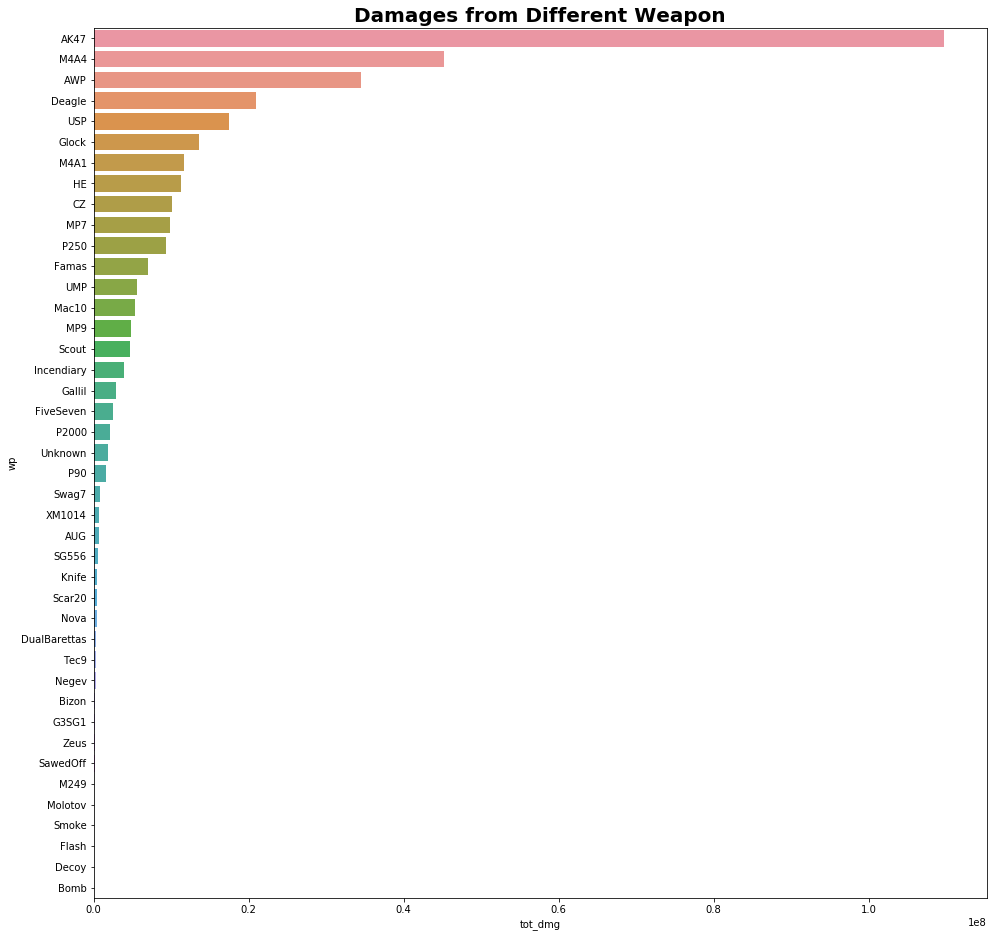

In [36]:
#画图显示不同武器造成的伤害
fig = plt.figure(figsize=(16, 16))
sns.barplot(y=dmg_wp_sum_pd['wp'],\
            x=dmg_wp_sum_pd['tot_dmg'],\
            )

plt.title('Damages from Different Weapon', fontsize=20, fontweight='bold')

([<matplotlib.patches.Wedge at 0x7f4bbad5c390>,
 [Text(-1.107732539722207, -0.07091276641472334, 'Rifle'),
  Text(0.8292104888269689, -0.752867827191028, 'Pistol'),
  Text(1.067682734596699, 0.37007239594992086, 'Sniper'),
  Text(0.66827687028211, 0.9358985119370306, 'SMG'),
  Text(0.2643035117218083, 1.1397559623408515, 'Grenade'),
  Text(0.08272889081862808, 1.2472593678236776, 'Heavy'),
  Text(0.03890180929940843, 1.3994594132139855, 'Unkown'),
  Text(0.008586211791186158, 1.5999769613863437, 'Equipment')],
 [Text(-0.6087539182257173, -0.038970078840523635, '52.0%'),
  Text(0.4590272348863577, -0.4167661186236047, '22.5%'),
  Text(0.5952567458370975, 0.2063235481844691, '11.6%'),
  Text(0.37772170928988824, 0.5289861154426694, '8.0%'),
  Text(0.15135329303727485, 0.6526807647592908, '4.5%'),
  Text(0.04963733449117684, 0.7483556206942065, '0.7%'),
  Text(0.025008305978191134, 0.8996524799232762, '0.5%'),
  Text(0.005903020606440483, 1.0999841609531111, '0.2%')])

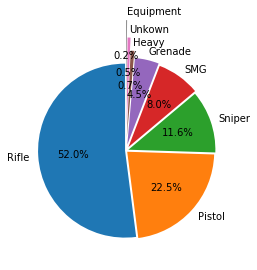

In [56]:
plt.pie(dmg_wp_type_sum_pd['tot_dmg'],labels=dmg_wp_type_sum_pd['wp_type'],startangle=90,autopct='%1.1f%%',explode = (0.01,0.02,0.03,0.05,0.07,0.15,0.3,0.5))


Text(0.5, 1.0, 'Damages from Different Weapon')

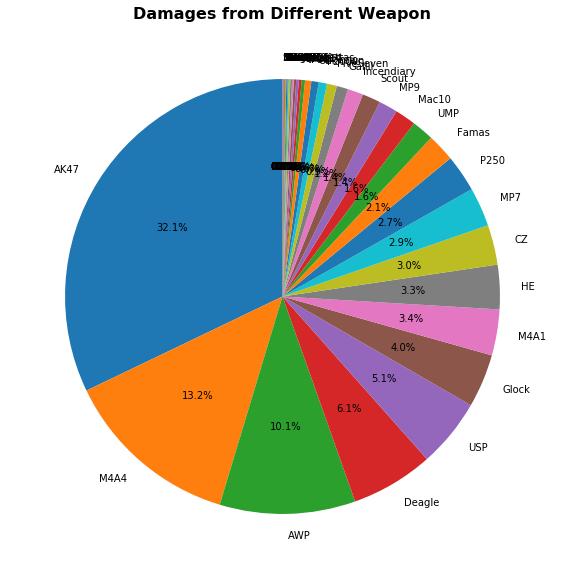

In [32]:
#画图显示不同武器造成的伤害
fig = plt.figure(figsize=(10, 10))
#plt.title('Demages from Different Weapon', fontsize=13, fontweight='bold')

plt.pie(dmg_wp_sum_pd['tot_dmg'],labels=dmg_wp_sum_pd['wp'],\
        startangle=90,autopct='%1.1f%%')#,explode = (0.01,0.02,0.03,0.05,0.07,0.15,0.3,0.5))

plt.title('Damages from Different Weapon', fontsize=16, fontweight='bold')

In [58]:
dmg_wp_sum_pd.head(10)

,wp,tot_dmg,hp_dmg,arm_dmg
0,AK47,109725947.0,98743694.0,10982253.0
1,M4A4,45141653.0,38014304.0,7127349.0
2,AWP,34445328.0,34013206.0,432122.0
3,Deagle,20967316.0,20171835.0,795481.0
4,USP,17441255.0,14527886.0,2913369.0
5,Glock,13562451.0,11582232.0,1980219.0
6,M4A1,11662392.0,9805285.0,1857107.0
7,HE,11262324.0,9033918.0,2228406.0
8,CZ,10135325.0,8941360.0,1193965.0
9,MP7,9900292.0,8372636.0,1527656.0


画图显示前10名和后10名：

Text(0.5, 0.98, 'Zoom of Weapon Dameges')

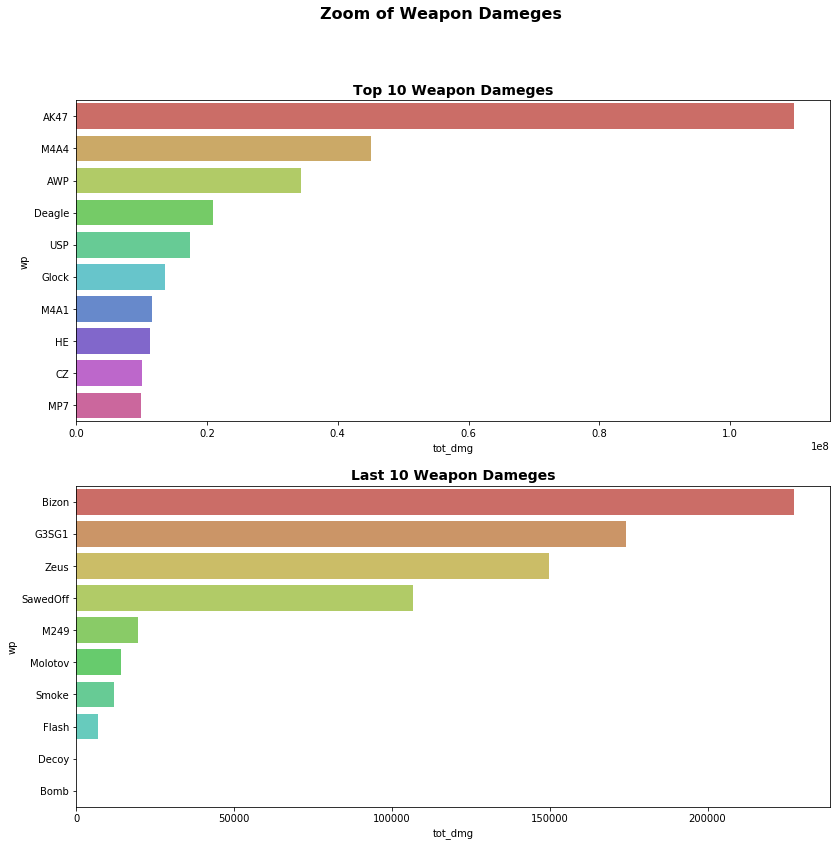

In [59]:
#画图显示不同武器造成的伤害
fig = plt.figure(figsize=(13.5, 13))
plt.subplot(2,1,1)
plt.title('Top 10 Weapon Dameges', fontsize=14, fontweight='bold')
sns.barplot(y=dmg_wp_sum_pd.head(10)['wp'],\
            x=dmg_wp_sum_pd.head(10)['tot_dmg'],\
            palette=sns.color_palette("hls", 10)\
            )
plt.subplot(2,1,2)
plt.title('Last 10 Weapon Dameges', fontsize=14, fontweight='bold')
sns.barplot(y=dmg_wp_sum_pd.tail(10)['wp'],\
            x=dmg_wp_sum_pd.tail(10)['tot_dmg'],\
            palette=sns.color_palette("hls", 15)\
            )
plt.suptitle('Zoom of Weapon Dameges', fontsize=16, fontweight='bold')

可以看出，最受欢迎的是AK47，。。。。。

下面删掉！

In [60]:
#'file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted, 
#bomb_site,hitbox,wp,wp_type,[att_id,att_rank,vic_id,vic_rank],att_pos_x,att_pos_y,vic_pos_x,vic_pos_y'

#dmg_wp_list=dmg_df.select('wp','wp_type','hp_dmg','arm_dmg').orderBy('wp_type')
#dmg_wp_list.show(50)

### 伤害部位排行

击伤部位有哪几种：

hitbox


In [21]:
#'file,round,tick,seconds,att_team,vic_team,att_side,vic_side,hp_dmg,arm_dmg,is_bomb_planted, 
#bomb_site,hitbox,wp,wp_type,[att_id,att_rank,vic_id,vic_rank],att_pos_x,att_pos_y,vic_pos_x,vic_pos_y'
dmg_hitbox_pd=dmg_wp_list.groupBy('hitbox').count().\
                orderBy('count',ascending=0 ).toPandas()
dmg_hitbox_pd

,hitbox,count
0,Chest,4225631
1,Stomach,1811283
2,Head,1478655
3,Generic,1394708
4,RightArm,715480
5,RightLeg,333583
6,LeftLeg,298783
7,LeftArm,258125
8,8,21934


伤害累积统计：

In [22]:
dmg_hitbox_sum=dmg_wp_list.groupBy('hitbox').agg({'hp_dmg': 'sum', 'arm_dmg': 'sum','tot_dmg': 'sum'}).\
                withColumnRenamed("sum(tot_dmg)", "tot_dmg").\
                withColumnRenamed("sum(hp_dmg)", "hp_dmg").\
                withColumnRenamed("sum(arm_dmg)", "arm_dmg").\
                orderBy('tot_dmg',ascending=0)
dmg_hitbox_sum_pd=dmg_hitbox_sum.toPandas()
dmg_hitbox_sum_pd

,hitbox,tot_dmg,hp_dmg,arm_dmg
0,Chest,115286584.0,102746528.0,12540056.0
1,Head,110507583.0,96296187.0,14211396.0
2,Stomach,57601555.0,50948744.0,6652811.0
3,RightArm,19570309.0,17501191.0,2069118.0
4,Generic,17688686.0,14860317.0,2828369.0
5,RightLeg,7112794.0,7112794.0,0.0
6,LeftArm,6935885.0,6165103.0,770782.0
7,LeftLeg,6319436.0,6319436.0,0.0
8,8,566094.0,496159.0,69935.0


In [23]:
print(dmg_hitbox_pd.to_latex())

\begin{tabular}{llr}
\toprule
{} &    hitbox &    count \\
\midrule
0 &     Chest &  4225631 \\
1 &   Stomach &  1811283 \\
2 &      Head &  1478655 \\
3 &   Generic &  1394708 \\
4 &  RightArm &   715480 \\
5 &  RightLeg &   333583 \\
6 &   LeftLeg &   298783 \\
7 &   LeftArm &   258125 \\
8 &         8 &    21934 \\
\bottomrule
\end{tabular}



In [24]:
print(dmg_hitbox_sum_pd.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &    hitbox &      tot\_dmg &       hp\_dmg &     arm\_dmg \\
\midrule
0 &     Chest &  115286584.0 &  102746528.0 &  12540056.0 \\
1 &      Head &  110507583.0 &   96296187.0 &  14211396.0 \\
2 &   Stomach &   57601555.0 &   50948744.0 &   6652811.0 \\
3 &  RightArm &   19570309.0 &   17501191.0 &   2069118.0 \\
4 &   Generic &   17688686.0 &   14860317.0 &   2828369.0 \\
5 &  RightLeg &    7112794.0 &    7112794.0 &         0.0 \\
6 &   LeftArm &    6935885.0 &    6165103.0 &    770782.0 \\
7 &   LeftLeg &    6319436.0 &    6319436.0 &         0.0 \\
8 &         8 &     566094.0 &     496159.0 &     69935.0 \\
\bottomrule
\end{tabular}



画图表示大家更容易打什么部位：

这里统计的不同击杀部位（hitbox）的**累积伤害量统计**。

Text(0.5, 0.98, 'Demage on Different Hitboxs')

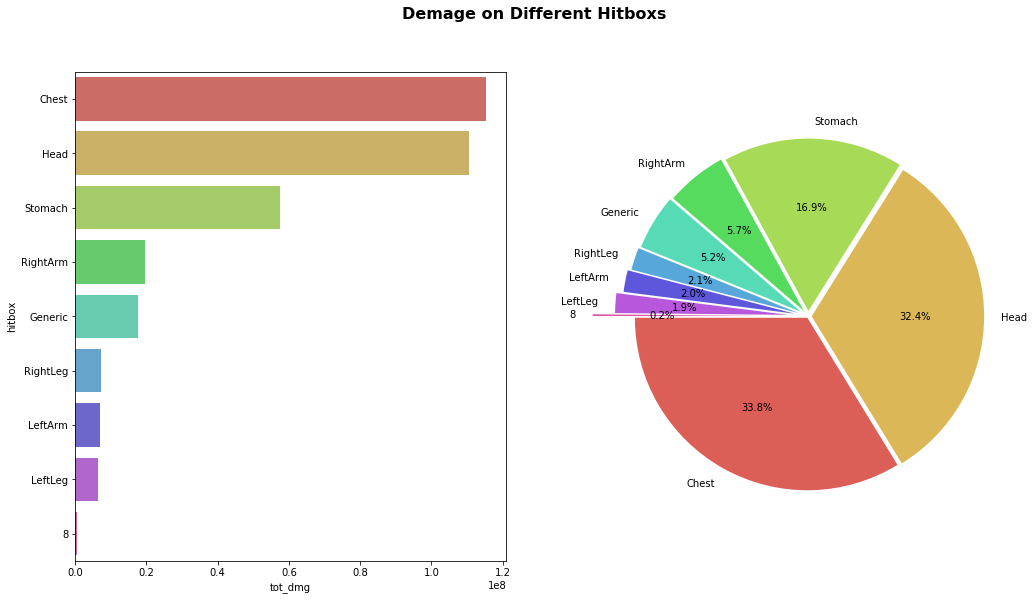

In [63]:
#from matplotlib import ticker
fig = plt.figure(figsize=(17, 9))
plt.subplot(1,2,1)
colors1=sns.color_palette("hls", 9)
sns.barplot(y=dmg_hitbox_sum_pd['hitbox'],x=dmg_hitbox_sum_pd['tot_dmg'],palette=colors1)
#.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

plt.subplot(1,2,2)
colors=sns.color_palette("hls", 9)
plt.pie(dmg_hitbox_sum_pd['tot_dmg'],labels=dmg_hitbox_sum_pd['hitbox'],\
        colors=colors1,startangle=180,\
        autopct='%1.1f%%',explode = (0.01,0.02,0.03,0.04,0.05,0.06,0.08,0.12,0.25))
plt.suptitle('Demage on Different Hitboxs', fontsize=16, fontweight='bold')

伤害条目的对比，胸最多，其次是肚子和头，这与不同部位的伤害量不同有关。

Text(0.5, 0.98, 'Records of Different Hitboxs')

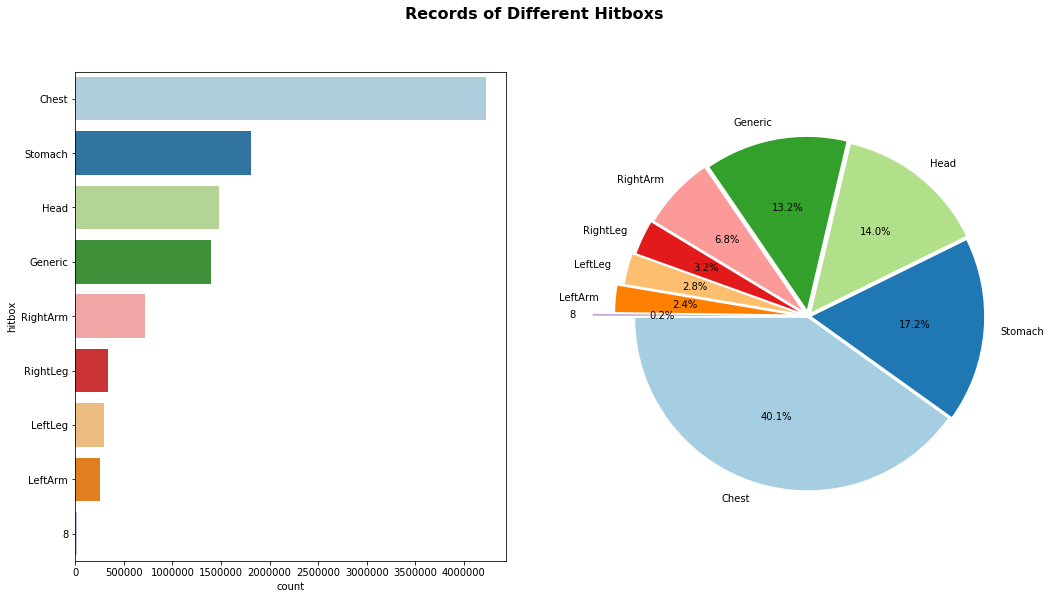

In [64]:
#from matplotlib import ticker
fig = plt.figure(figsize=(17, 9))
plt.subplot(1,2,1)
colors1=sns.color_palette("Paired",10)
sns.barplot(y=dmg_hitbox_pd['hitbox'],x=dmg_hitbox_pd['count'],palette=colors1)
#.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))

plt.subplot(1,2,2)
colors=sns.color_palette("hls", 9)
plt.pie(dmg_hitbox_pd['count'],labels=dmg_hitbox_pd['hitbox'],\
        colors=colors1,startangle=180,\
        autopct='%1.1f%%',explode = (0.01,0.02,0.03,0.04,0.05,0.06,0.08,0.12,0.25))
plt.suptitle('Records of Different Hitboxs', fontsize=16, fontweight='bold')

可以看出，肚子的伤害条目多于头，但是头的总伤害量高于肚子。

打腿没有甲。

> 可以看出，所有武器的综合爆头率，（也可以理解为所有玩家在比赛中的综合爆头率），只有16%，比赛中更多的伤害，还是依靠长枪击中胸部和腹部产生的。

In [65]:
#dmg_df.select('wp','wp_type','hp_dmg','arm_dmg','hitbox').#filter("hitbox='8'").show(40)

In [66]:
#countsRDD = stringRDD.map(lambda word : (word, 1)).reduceByKey(lambda x,y : x+y)

### 枪械爆头率排行

爆头率：

$$
\rm{Head \ Shot\ Rate}=\frac{\rm{Count\ of\ Head}}{\rm{Count\ of\ ALL\ Hitbox}}
$$

In [67]:
dmg_all_hit_1=dmg_wp_list.groupBy('wp','hitbox').count().\
                orderBy('count',ascending=0 )
dmg_all_hit_1.show(50)

+----------+--------+-------+
|        wp|  hitbox|  count|
+----------+--------+-------+
|      AK47|   Chest|1385042|
|Incendiary| Generic| 782888|
|      AK47| Stomach| 668950|
|      M4A4|   Chest| 668417|
|      AK47|    Head| 473126|
|        HE| Generic| 469987|
|      M4A4| Stomach| 323452|
|      AK47|RightArm| 245840|
|       USP|   Chest| 230610|
|     Glock|   Chest| 220570|
|       AWP|   Chest| 219290|
|    Deagle|   Chest| 201443|
|       MP7|   Chest| 198903|
|      M4A4|    Head| 194640|
|      M4A1|   Chest| 165586|
|        CZ|   Chest| 153662|
|       USP|    Head| 130791|
|      AK47|RightLeg| 129086|
|      M4A4|RightArm| 119075|
|      P250|   Chest| 117749|
|     Glock|    Head| 116769|
|      AK47| LeftLeg| 115310|
|     Famas|   Chest| 107791|
|   Unknown| Generic| 103280|
|     Mac10|   Chest| 100844|
|    Deagle|    Head| 100688|
|       UMP|   Chest|  99328|
|       MP7| Stomach|  99026|
|       MP9|   Chest|  96944|
|      AK47| LeftArm|  89674|
|       AW

In [8]:
#全部伤害条目
dmg_all_hit=dmg_wp_list.groupBy('wp').count().orderBy('count',ascending=0 ).toPandas().head(40)
#击中头部的条目
dmg_head_hit=dmg_wp_list.filter("hitbox='Head'").groupBy('wp').count().withColumnRenamed("count", "count_h").\
                         orderBy('count_h',ascending=0 ).toPandas()

#dmg_all_hit.join(dmg_head_hit ,dmg_all_hit.wp == dmg_head_hit.wp, "left_outer")

In [9]:
#链接表
#在Pandas中join
dmg_head_rate=dmg_head_hit.join(dmg_all_hit.set_index('wp'), on='wp')
#计算爆头率
dmg_head_rate['head_rate']=dmg_head_rate['count_h']/dmg_head_rate['count']
dmg_head_rate=dmg_head_rate.sort_values('head_rate',ascending=0 )
dmg_head_rate

,wp,count_h,count,head_rate
2,USP,130791,462254,0.282942
15,P2000,15398,56231,0.273835
3,Glock,116769,435716,0.267993
4,Deagle,100688,426307,0.236187
16,Scout,14469,64328,0.224925
6,P250,52273,249322,0.209661
24,DualBarettas,1976,9659,0.204576
14,FiveSeven,15793,80439,0.196335
25,Tec9,1868,9786,0.190885
29,SawedOff,713,4126,0.172807


In [10]:
print(dmg_head_rate.to_latex())

\begin{tabular}{llrrr}
\toprule
{} &            wp &  count\_h &    count &  head\_rate \\
\midrule
2  &           USP &   130791 &   462254 &   0.282942 \\
15 &         P2000 &    15398 &    56231 &   0.273835 \\
3  &         Glock &   116769 &   435716 &   0.267993 \\
4  &        Deagle &   100688 &   426307 &   0.236187 \\
16 &         Scout &    14469 &    64328 &   0.224925 \\
6  &          P250 &    52273 &   249322 &   0.209661 \\
24 &  DualBarettas &     1976 &     9659 &   0.204576 \\
14 &     FiveSeven &    15793 &    80439 &   0.196335 \\
25 &          Tec9 &     1868 &     9786 &   0.190885 \\
29 &      SawedOff &      713 &     4126 &   0.172807 \\
19 &         Swag7 &     6556 &    38449 &   0.170512 \\
11 &           MP9 &    31833 &   197649 &   0.161058 \\
5  &            CZ &    54508 &   340874 &   0.159907 \\
21 &          Nova &     2828 &    17900 &   0.157989 \\
0  &          AK47 &   473126 &  3115867 &   0.151844 \\
10 &         Mac10 &    32604 &   218457 &   

画图：

Text(0.5, 0.98, 'Head Shot Rate of Weapons')

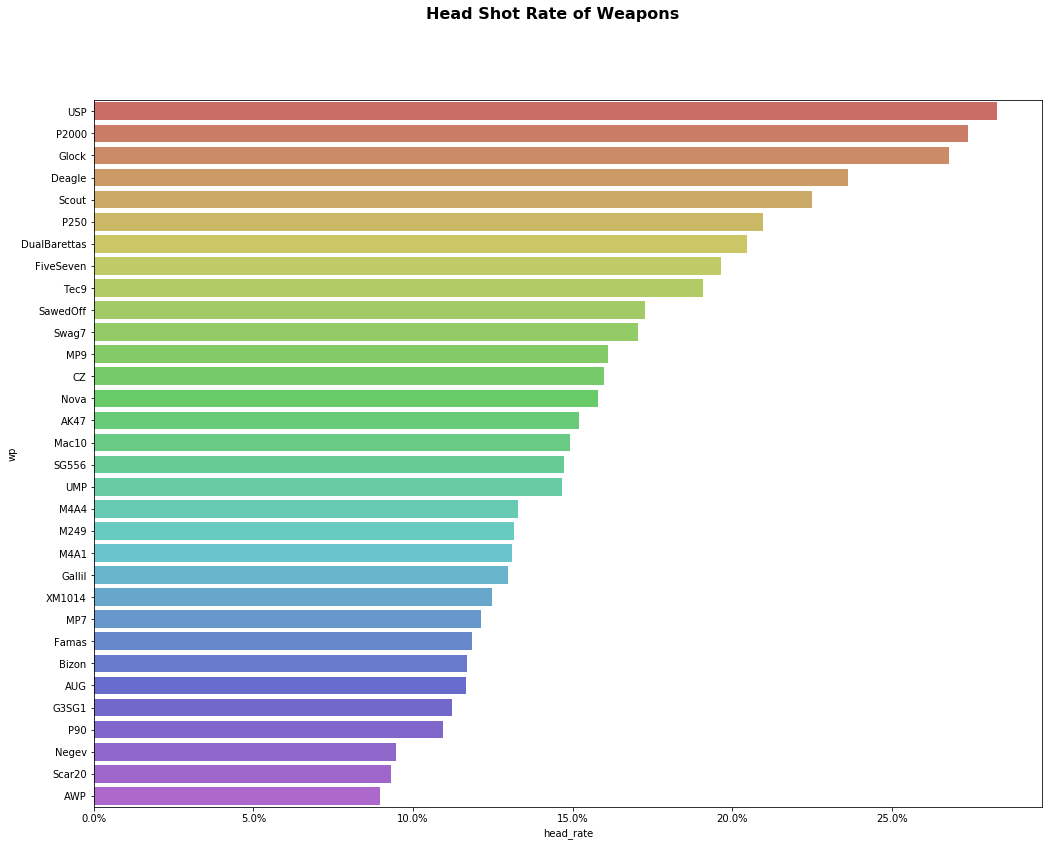

In [70]:
#from matplotlib import ticker
fig = plt.figure(figsize=(17, 13))
#plt.subplot(1,2,1)
colors1=sns.color_palette("hls",40)
sns.barplot(y=dmg_head_rate['wp'],x=dmg_head_rate['head_rate'],palette=colors1)\
            .xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.suptitle('Head Shot Rate of Weapons', fontsize=16, fontweight='bold')

### 威力排行

all_dmg/all_count

即计算**ADR**, Attack Damage Ratio

In [13]:
#链接表
wp_dmg_rate=dmg_wp_sum_pd.join(dmg_count.set_index('wp'), on='wp')
#计算单发伤害
wp_dmg_rate['dmg_rate']=wp_dmg_rate['tot_dmg']/wp_dmg_rate['count']
wp_dmg_rate=wp_dmg_rate.sort_values('dmg_rate',ascending=0 )
wp_dmg_rate

,wp,tot_dmg,hp_dmg,arm_dmg,wp_type,count,dmg_rate
34,Zeus,149643.0,149643.0,0.0,Equipment,1738,86.100690
2,AWP,34445328.0,34013206.0,432122.0,Sniper,415525,82.895922
15,Scout,4642997.0,4158674.0,484323.0,Sniper,64328,72.176921
27,Scar20,432829.0,382646.0,50183.0,Sniper,7870,54.997332
33,G3SG1,174113.0,156052.0,18061.0,Sniper,3189,54.597993
26,Knife,433870.0,393608.0,40262.0,Equipment,8673,50.025366
3,Deagle,20967316.0,20171835.0,795481.0,Pistol,426307,49.183607
4,USP,17441255.0,14527886.0,2913369.0,Pistol,462254,37.730890
10,P250,9383852.0,7419927.0,1963925.0,Pistol,249322,37.637481
19,P2000,2104648.0,1744828.0,359820.0,Pistol,56231,37.428607


In [15]:
print(wp_dmg_rate.to_latex
      ())

\begin{tabular}{llrrrlrr}
\toprule
{} &            wp &      tot\_dmg &      hp\_dmg &     arm\_dmg &    wp\_type &    count &   dmg\_rate \\
\midrule
34 &          Zeus &     149643.0 &    149643.0 &         0.0 &  Equipment &     1738 &  86.100690 \\
2  &           AWP &   34445328.0 &  34013206.0 &    432122.0 &     Sniper &   415525 &  82.895922 \\
15 &         Scout &    4642997.0 &   4158674.0 &    484323.0 &     Sniper &    64328 &  72.176921 \\
27 &        Scar20 &     432829.0 &    382646.0 &     50183.0 &     Sniper &     7870 &  54.997332 \\
33 &         G3SG1 &     174113.0 &    156052.0 &     18061.0 &     Sniper &     3189 &  54.597993 \\
26 &         Knife &     433870.0 &    393608.0 &     40262.0 &  Equipment &     8673 &  50.025366 \\
3  &        Deagle &   20967316.0 &  20171835.0 &    795481.0 &     Pistol &   426307 &  49.183607 \\
4  &           USP &   17441255.0 &  14527886.0 &   2913369.0 &     Pistol &   462254 &  37.730890 \\
10 &          P250 &    9383852.0

Text(0.5, 0.98, 'Average Demage per Shot of Weapons')

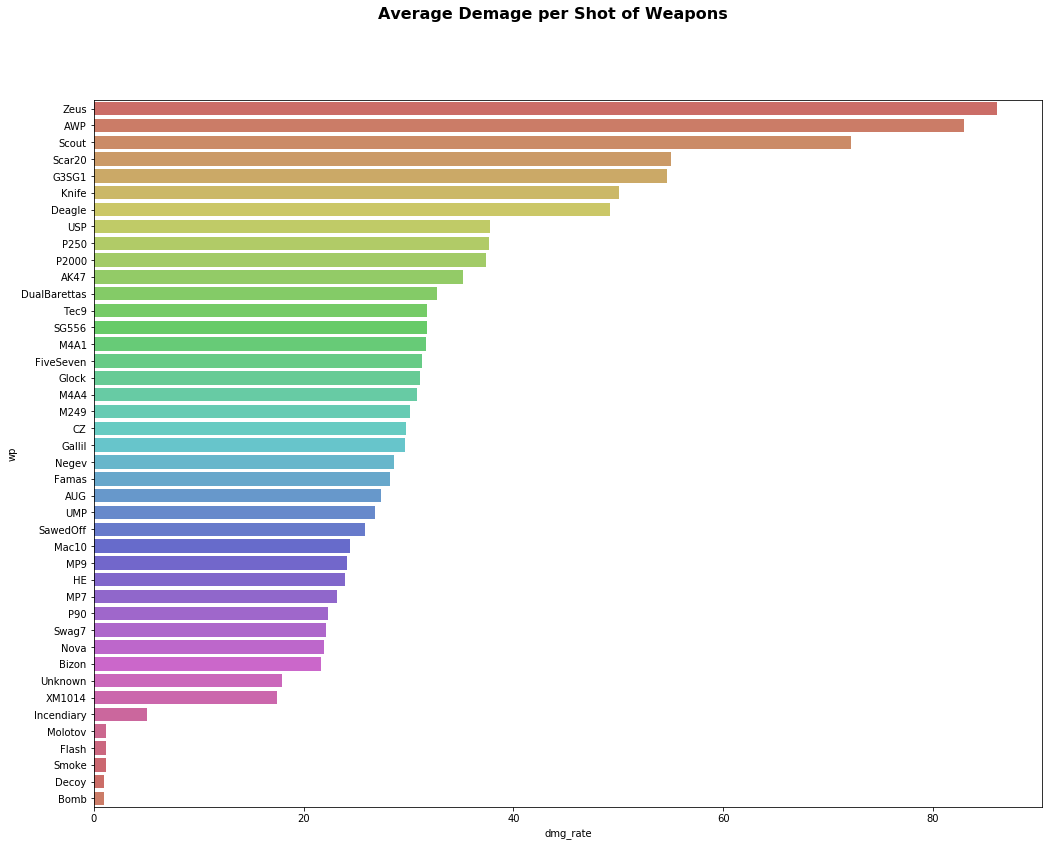

In [72]:
#from matplotlib import ticker
fig = plt.figure(figsize=(17, 13))
#plt.subplot(1,2,1)
colors1=sns.color_palette("hls",40)
sns.barplot(y=wp_dmg_rate['wp'],x=wp_dmg_rate['dmg_rate'],palette=colors1)\
           # .xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.suptitle('Average Demage per Shot of Weapons', fontsize=16, fontweight='bold')

可以判断爆头率与威力的相关性曲线

# kill表分析

##  不同枪械击杀次数排行榜 `wp`

可以做成不同type的头10名

In [10]:
kill_count=kill_df.select('wp','wp_type').groupBy('wp_type','wp').count().orderBy('count',ascending=0).toPandas()
kill_count

,wp_type,wp,count
0,Rifle,AK47,949525
1,Sniper,AWP,366900
2,Rifle,M4A4,356118
3,Pistol,Deagle,170734
4,Pistol,USP,132761
5,Pistol,Glock,104182
6,Rifle,M4A1,92343
7,SMG,MP7,76940
8,Pistol,CZ,73813
9,Pistol,P250,62615


Text(0.5, 1.0, 'Kill Counting of Weapons')

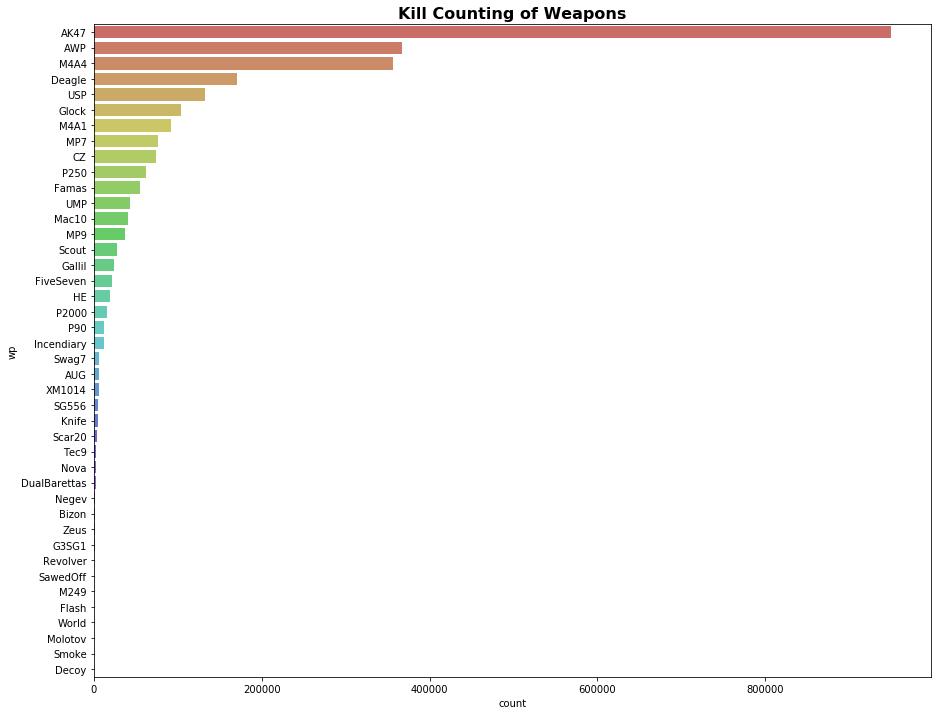

In [44]:
#from matplotlib import ticker
fig = plt.figure(figsize=(15, 12))
#plt.subplot(1,2,1)
colors1=sns.color_palette("hls",40)
sns.barplot(y=kill_count['wp'],x=kill_count['count'],palette=colors1)\
           # .xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.title('Kill Counting of Weapons', fontsize=16, fontweight='bold')

现选择部分列：

In [75]:
#file,round,tick,seconds,att_team,vic_team,att_side,vic_side,wp,wp_type,ct_alive,t_alive,is_bomb_planted
kill_list=kill_df.select('wp','wp_type','att_side','ct_alive','t_alive','is_bomb_planted').orderBy('wp')
kill_list.show(50)

+----+-------+----------------+--------+-------+---------------+
|  wp|wp_type|        att_side|ct_alive|t_alive|is_bomb_planted|
+----+-------+----------------+--------+-------+---------------+
|AK47|  Rifle|       Terrorist|       4|      5|          False|
|AK47|  Rifle|       Terrorist|       3|      5|          False|
|AK47|  Rifle|       Terrorist|       4|      5|          False|
|AK47|  Rifle|       Terrorist|       2|      3|          False|
|AK47|  Rifle|       Terrorist|       3|      5|          False|
|AK47|  Rifle|CounterTerrorist|       1|      2|           True|
|AK47|  Rifle|       Terrorist|       2|      5|          False|
|AK47|  Rifle|       Terrorist|       3|      3|          False|
|AK47|  Rifle|       Terrorist|       1|      5|          False|
|AK47|  Rifle|CounterTerrorist|       5|      3|          False|
|AK47|  Rifle|       Terrorist|       0|      5|           True|
|AK47|  Rifle|       Terrorist|       4|      2|          False|
|AK47|  Rifle|       Terr

## CT剩余1人时用的枪最多

筛选出 CT还剩余1人时，击杀方时CT的数据

In [45]:
kill_ct_1_pd=kill_df.select('wp','wp_type','att_side','ct_alive','t_alive','is_bomb_planted').\
                filter("ct_alive='1' and att_side='CounterTerrorist'").groupBy('wp').\
                count().orderBy('count',ascending=0).toPandas()
kill_ct_1_pd

,wp,count
0,AK47,26436
1,M4A4,25629
2,AWP,17517
3,USP,12380
4,Deagle,10976
5,M4A1,6555
6,CZ,4837
7,P250,4008
8,Famas,3488
9,MP7,2993


画图显示，CT还剩余1人时，CT造成击杀的枪的排名：

Text(0.5, 1.0, 'Kill Counting of Weapons when 1 CT alives')

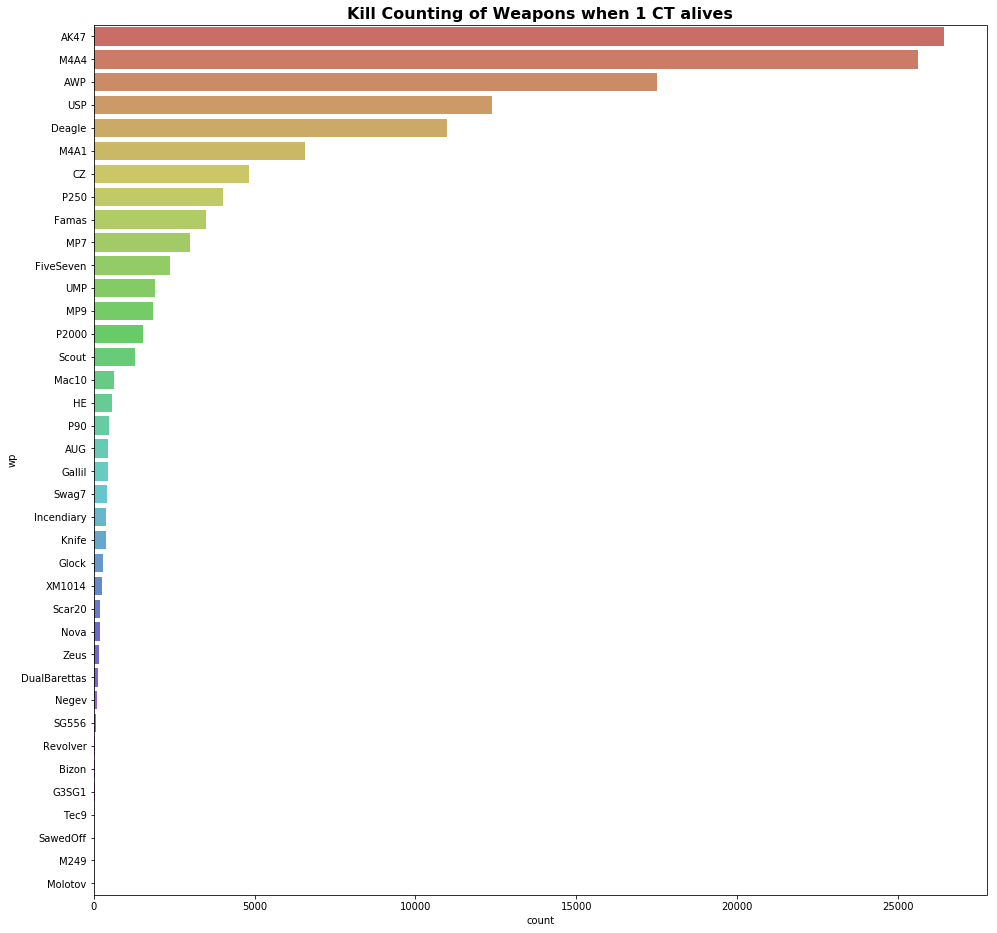

In [46]:
fig = plt.figure(figsize=(16, 16))
#plt.subplot(1,2,1)
colors1=sns.color_palette("hls",40)
sns.barplot(y=kill_ct_1_pd['wp'],x=kill_ct_1_pd['count'],palette=colors1)\
           # .xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=1))
plt.title('Kill Counting of Weapons when 1 CT alives', fontsize=16, fontweight='bold')

It is clearly to see that CTs are most likely to give a kill by AK-47 taken from T side.